In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as optimize
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import pickle
import scipy.ndimage
from matplotlib import animation
from IPython.display import display, HTML
from matplotlib import path
import matplotlib.patches as patches
from scipy.optimize import curve_fit

import finesse
from finesse.gaussian import BeamParam
from finesse.analysis.actions import RunLocks, Noxaxis, Xaxis
from finesse.analysis.actions.locks import RunLocks
from finesse import ligo
from finesse.knm.maps import Map
from finesse.utilities.maps import circular_aperture, surface_point_absorber as spa

from LLOF3NoSqz import make_LLO

finesse.configure(plotting=True)

import warnings
warnings.filterwarnings('ignore')

    Reference: 
[1] [LLO](https://git.ligo.org/IFOsim/Finesse_playground/-/blob/master/LIGO/LLO.py)

[2] [aLOG-59815](https://alog.ligo-la.caltech.edu/aLOG/index.php?callRep=59815)

In [2]:
LIGOIFO = finesse.Model()
LIGOIFO.parse_file("LIGO_degisn_NOCP.txt")

LLObase = make_LLO(LIGOIFO.deepcopy(), isCP=False) # make LLO according to reference [1]
LLObase.modes(maxtem=6)

LLObase.mod1.midx = 0.135 # updated modulation depth, reference [2]
LLObase.mod2.midx = 0.174

LLObase.DARM.DC = 0.00138 # match the AS power
LLObase.remove(LLObase.DARM_dc_lock)

lossX = 11.674e-6  # point absorber loss, match the PRG
lossY = 11.674e-6 
LLObase.ETMY.set_RTL(L=4e-05+lossY, T=3.9e-06)
LLObase.ETMX.set_RTL(L=4e-05+lossX, T=4e-06)

# match the REFL power measurement
LLObase.parse("""
gauss input PRMAR.p1.i priority=1 w=0.0022059792704101624 S=0.12974801396064709
""")

delta = 1.9985e-4 # match the REFL power measurement
pr2pr3 = 16.1648
LLObase.lp2.L = pr2pr3*(1-delta)

ly1 (BS to ITMY) is 5.012 m
lx1 (BS to ITMX) is 4.995 m


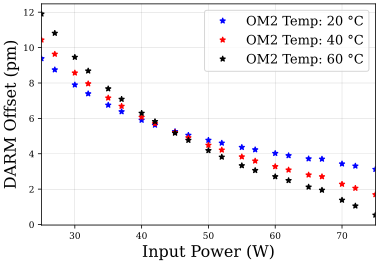

In [10]:
# Keep the AS carrier power fixed at 25 mW as the input power is increased, for different OM2 temperatures

inputPower = [25, 27, 30, 32, 35, 37, 40, 42, 45, 47, 50, 52, 55, 57, 60, 62, 65, 67, 70, 72, 75, ]#80]
DARMDC20 = [0.001587, 0.00148, 0.0013357, 0.0012511, 0.0011425, 0.00107953, 0.0009985, 0.00095165,
            0.0008898, 0.0008547, 0.00080668, 0.00077957, 0.0007384, 0.0007157, 0.0006809, 0.00065935,
            0.0006291, 0.00062641, 0.0005804, 0.00056032, 0.0005283, ]#0.0005555,]

DARMDC40 = [0.0017657, 0.00162965, 0.00145011, 0.0013465, 0.0012108, 0.0011317, 0.00102677, 0.00096514,
            0.00088143, 0.00083045, 0.0007592, 0.00071326, 0.000648, 0.00060826, 0.0005548, 0.00052243,
            0.0004747, 0.00045815, 0.0003865, 0.0003478, 0.0002863, ]#0.0003575, ]

DARMDC60 = [0.002014, 0.00182965, 0.0016, 0.0014692, 0.0012986, 0.0011986, 0.001065, 0.00098502,
            0.0008747, 0.00080625, 0.00070805, 0.00064575, 0.0005635, 0.0005177, 0.0004585, 0.0004215,
            0.0003593, 0.0003294, 0.000234, 0.0001784, 0.0000912, ]#0.0001995,]

# DARMDC20 = np.array(DARMDC20)*2*1064e3/360
# DARMDC40 = np.array(DARMDC40)*2*1064e3/360
# DARMDC60 = np.array(DARMDC60)*2*1064e3/360

def DARMDFUNC20(x, a, b, c, d, e, f):
    return a * x**(-1) + b * x**(-2) + c* x**(1) + d* x**(2) + e* x**(3)+ f* x**(-3)

def DARMDFUNC40(x, a, b, c, d, e, f):
    return a * x**(-1) + b * x**(-2) + c* x**(1) + d* x**(2) + e* x**(3)+ f* x**(-3)

def DARMDFUNC60(x, a, b, c, d, e, f):
    return a * x**(-1) + b * x**(-2) + c* x**(1) + d* x**(2) + e* x**(3)+ f* x**(-3)


popt20, pcov20 = curve_fit(DARMDFUNC20, inputPower, DARMDC20)
popt40, pcov40 = curve_fit(DARMDFUNC40, inputPower, DARMDC40)
popt60, pcov60 = curve_fit(DARMDFUNC60, inputPower, DARMDC60)

# print(popt)
xaxis = np.linspace(25, 75, 200)
yaxis20 = DARMDFUNC20(np.linspace(25, 75, 200), *popt20)
yaxis40 = DARMDFUNC40(np.linspace(25, 75, 200), *popt40)
yaxis60 = DARMDFUNC60(np.linspace(25, 75, 200), *popt60)

DARMDC20 = np.array(DARMDC20)*2*1064e3/360
DARMDC40 = np.array(DARMDC40)*2*1064e3/360
DARMDC60 = np.array(DARMDC60)*2*1064e3/360

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(inputPower, DARMDC20, "*", label="OM2 Temp: 20 °C")
# plt.plot(xaxis, yaxis20);

ax.plot(inputPower, DARMDC40, "*", label="OM2 Temp: 40 °C")
# plt.plot(xaxis, yaxis40);

ax.plot(inputPower, DARMDC60, "*", label="OM2 Temp: 60 °C")
# plt.plot(xaxis, yaxis60);

ax.set_ylabel("DARM Offset (pm)", fontsize=16)
ax.set_xlabel("Input Power (W)", fontsize=16)

ax.legend(fontsize=13);
# fig.savefig('darmoffset.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [11]:
LLObase.cavOMC.FSR/LLObase.cavOMC.finesse

643941.1910382796

In [12]:
LLObase.OMC_IC.T, LLObase.OMC_OC.T, LLObase.OMC_CM1.T, LLObase.OMC_CM2.T, 

(<OMC_IC.T=0.0076 @ 0x14a60f340>,
 <OMC_OC.T=0.0075 @ 0x14a60fa00>,
 <OMC_CM1.T=3.6e-05 @ 0x14a724100>,
 <OMC_CM2.T=3.59e-05 @ 0x14a7247c0>)

In [13]:
Defocus60 = 1/1.515
Defocus20 = 1/1.908

Defocus40 = Defocus20 + (Defocus60-Defocus20)/(60-20)*(40-20)
Defocus25 = Defocus20 + (Defocus60-Defocus20)/(60-20)*(25-20)

RoC40 = 1/Defocus40
RoC25 = 1/Defocus25
RoC60 = 1/Defocus60
RoC20 = 1/Defocus20

RoC20, RoC25, RoC40, RoC60, 

(1.908, 1.848074802205706, 1.6889395267309377, 1.5150000000000001)

In [16]:
defocusx_0 = 3.3e-6
defocusy_0 = -11.4e-6

defocusx_1 = 55.8e-6
defocusy_1 = 44.4e-6

ITMXRoC_0 = 1938.1
ITMYRoC_0 = 1940.9

ITMXRoC_1 = 1958.4
ITMYRoC_1 = 1962.4

ETMXRoC_0 = 2239.7
ETMYRoC_0 = 2234

ETMXRoC_1 = 2259.8
ETMYRoC_1 = 2254.6

def updateITMs(kat, Px, Py):
    defocusx = defocusx_0 + Px*(defocusx_1-defocusx_0)/220e3
    defocusy = defocusy_0 + Py*(defocusy_1-defocusy_0)/220e3

    kat.lensfX.value = 1/defocusx
    kat.lensfY.value = 1/defocusy

    ITMXD = 1/ITMXRoC_0 + Px*(1/ITMXRoC_1-1/ITMXRoC_0)/220e3
    kat.ITMX.Rc = -1/ITMXD

    ITMYD = 1/ITMYRoC_0 + Py*(1/ITMYRoC_1-1/ITMYRoC_0)/220e3
    kat.ITMY.Rc = -1/ITMYD

    ETMXD = 1/ETMXRoC_0 + Px*(1/ETMXRoC_1-1/ETMXRoC_0)/220e3
    kat.ETMX.Rc = 1/ETMXD

    ETMYD = 1/ETMYRoC_0 + Py*(1/ETMYRoC_1-1/ETMYRoC_0)/220e3
    kat.ETMY.Rc = 1/ETMYD
    
    return kat


def getARMP(kat):
    out = kat.run("""
    noxaxis(pre_step=run_locks(method='proportional', 
            display_progress=false, max_iterations=100000))
    """)
    
    
    return np.abs(out["Px"]), np.abs(out["Py"])


def getARMP_OG(kat):
    sol_lock = kat.run(RunLocks(method="proportional",
                                        display_progress=False,
                                        max_iterations=100000,
                                        scale_factor=0.8))

    out = kat.run(f"""
    fsig(1)
    frequency_response(
    [10],  # frequency vector
    [DARM,],  # injection nodes, dof DARM
    AS.DC,  # OMC_OC.p3.o DC, AS port
    )

     """) 
    
    out1 = kat.run(f"""
    noxaxis(pre_step=run_locks(method='proportional', 
            display_progress=false, max_iterations=100000))

     """) 

    return np.abs(out["frequency_response"]), np.abs(out1["Px"]), np.abs(out1["Py"])


def getARMP_CarrierAMP(kat):
    sol_lock = kat.run(RunLocks(method="proportional",
                                        display_progress=False,
                                        max_iterations=100000,
                                        scale_factor=0.8))

    kat.parse("""
    fsig(10) # model 10Hz oscillations
    sgen sig DARM amplitude=1e-11
    #pd1 P_Signal OMC_OC.p3.o f=&fsig
    #pd1 P_Carrier OMC_OC.p3.o f=0
    ad P_Signal OMC_OC.p3.o f=&fsig
    ad P_Carrier OMC_OC.p3.o f=0
    
    """)
    
    out = kat.run() 
    
#     return np.abs(out["P_Carrier"])**2, np.abs(out["P_Signal"])**2
    return np.abs(out["P_Carrier"]), np.abs(out["P_Signal"])

def getBP(kat):
    kat.parse("""
    bp OM3w OM3.p2.o w direction=x
    bp OM3s OM3.p2.o s direction=x

    """)
    out = kat.run()

    return out["OM3w"], out["OM3s"]

In [17]:
LLObase0 = LLObase.deepcopy()

LLObase0.OM2.Rc = RoC60

Pxs = []
Pys = []  
    
for Pin in [72]:
# for Pin in np.linspace(30, 90, 200):
    kat = LLObase0.deepcopy()
    kat.L0.P = Pin
    kat.DARM.DC = 0.0001784

    PARM0 = ARMFinesse*43*Pin/np.pi
    Px = PARM0
    Py = PARM0
    for i in range(1, 7):
        print(f"###### {i} step: ######")
        kat = updateITMs(kat, Px, Py)
        if i==6:
            kat.parse("""
            ad ASC2 OMC_OC.p3.o f=0
            noxaxis(pre_step=run_locks(method='proportional', 
                    display_progress=false, max_iterations=10000))
            """)
            out = kat.run()
            break
        Px, Py = getARMP(kat)

    print(np.abs(out["ASC2"])**2)

    Pxs.append(out["Px"])
    Pys.append(out["Py"])

###### 1 step: ######
###### 2 step: ######
###### 3 step: ######
###### 4 step: ######
###### 5 step: ######
###### 6 step: ######
0.0009569695826591617


In [18]:
print(LLObase.cavXARM.finesse, LLObase.cavYARM.finesse)

ARMFinesse = LLObase.cavXARM.finesse

PARM0 = ARMFinesse*43*40/np.pi
print(PARM0)

419.0825739343322 419.0711830201927
229444.77742631338


In [10]:
# kat = LLObase.deepcopy()

# kat = updateITMs(kat, PARM0, PARM0)
# getARMP_OG(kat)
# (16389986079.157303, 220860.8214304603, 221796.19964359954)

In [20]:
Pin = 75
LLObase1 = LLObase.deepcopy()
LLObase1.OM2.Rc = RoC40

kat = LLObase1.deepcopy()

kat.L0.P = Pin
kat.DARM.DC = DARMDFUNC40(Pin, *popt40)

PARM0 = ARMFinesse*43*Pin/np.pi
Pxs = [PARM0]
Pys = [PARM0]

for i in range(1, 12):
    print(f"###### {i} step: ######")
    kat = updateITMs(kat, Pxs[i-1], Pys[i-1])
    Px, Py = getARMP(kat)
    
    Pxs.append(Px)
    Pys.append(Py)

###### 1 step: ######
###### 2 step: ######
###### 3 step: ######
###### 4 step: ######
###### 5 step: ######
###### 6 step: ######
###### 7 step: ######
###### 8 step: ######
###### 9 step: ######
###### 10 step: ######
###### 11 step: ######


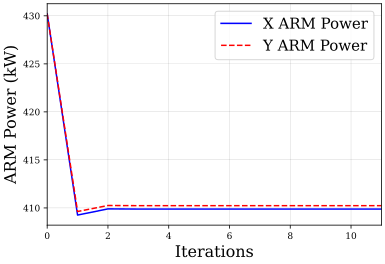

In [21]:
fig, ax =plt.subplots(1,1,figsize=(6,4))
ax.plot(range(12), np.array(Pxs)/1e3, label="X ARM Power")
ax.plot(range(12), np.array(Pys)/1e3, "--", label="Y ARM Power")

# ax.set_xticks([0, 1, 2, 3, 4, 5])
# ax.set_xticklabels([0, 1, 2, 3, 4, 5], fontsize=10)
ax.set_ylabel("ARM Power (kW)", fontsize=16)
ax.set_xlabel("Iterations", fontsize=16)

# ax.set_ylim([400, 407])
ax.legend(fontsize=15);
# fig.savefig('armpowerConvergence.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [12]:
Pxs0 = []
Pys0 = []
LLObase1 = LLObase.deepcopy()
LLObase1.OM2.Rc = RoC40
LLObase1.modes("off")
for idx, Pin in enumerate(inputPower):
    kat = LLObase1.deepcopy()

    kat.DARM.DC = DARMDFUNC40(Pin, *popt40)
    kat.L0.P = Pin

    PARM0 = ARMFinesse*43*Pin/np.pi
    Px = PARM0
    Py = PARM0
    for i in range(1, 2):
        kat = updateITMs(kat, Px, Py)
        Px, Py = getARMP(kat)
    Pxs0.append(Px)
    Pys0.append(Py)
    
    del(kat)

    if idx%30 == 0:
        print(f"{idx} is done...")
        print(Px)
        print(Py)

0 is done...
138499.68757145223
138495.7213451784


In [13]:
# np.save("PxssRoC20.npy", Pxs,)
# np.save("PyssRoC20.npy", Pys,)

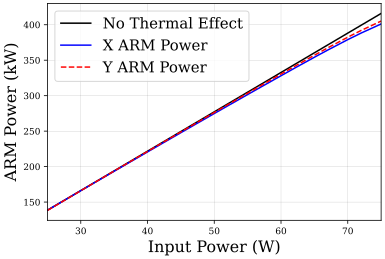

In [28]:
Pxs = np.load("PxssRoC20.npy")
Pys = np.load("PyssRoC20.npy")
# PARM0 = ARMFinesse*42.9*inputPower/np.pi

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(inputPower, np.array(Pxs0)/1e3, 'k', label="No Thermal Effect")
ax.plot(inputPower, np.array(Pxs)/1e3, 'b', label="X ARM Power")
ax.plot(inputPower, np.array(Pys)/1e3, 'r--', label="Y ARM Power")

# ax.set_xticks([0, 1, 2, 3])
# ax.set_xticklabels([0, 1, 2, 3], fontsize=10)
ax.set_ylabel("ARM Power (kW)", fontsize=16)
ax.set_xlabel("Input Power (W)", fontsize=16)
ax.legend(fontsize=15);
# fig.savefig('armpowerS.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [30]:
idx = np.abs((np.array(Pxs) - 4e5)).argmin()
inputPower[idx]
# This is the input power that gives us the correct circulating power

75

In [49]:
def TF(kat):
    sol_lock = kat.run(RunLocks(method="proportional",
                                        display_progress=False,
                                        max_iterations=100000,
                                        scale_factor=0.8))

    out = kat.run(f"""
    fsig(1)
    frequency_response(
    geomspace(10, 1k, 100),  # frequency vector
    [DARM,],  # injection nodes, dof DARM
    AS.DC,  # OMC_OC.p3.o DC, AS port
    )

     """) 
    
    return np.abs(out["frequency_response"])

def TFplot(OM2Rc=RoC40, inputP=40):
    LLObase1 = LLObase.deepcopy()

    LLObase1.OM2.Rc = OM2Rc

    for idx, Pin in enumerate([inputP]):
        kat = LLObase1.deepcopy()

        kat.DARM.DC = DARMDC40[(np.abs(np.array(inputPower)-inputP)).argmin()]

        kat.L0.P = Pin

        PARM0 = ARMFinesse*43*Pin/np.pi
        Px = PARM0
        Py = PARM0
        for i in range(1, 7):
            if i!=6:
                kat = updateITMs(kat, Px, Py)
                Px, Py = getARMP(kat)
            else:
                kat = updateITMs(kat, Px, Py)
                tfs = TF(kat)
                
    return tfs

In [50]:
tf220 = TFplot(inputP=40)
tf400 = TFplot(inputP=75)

1.2687404299324059


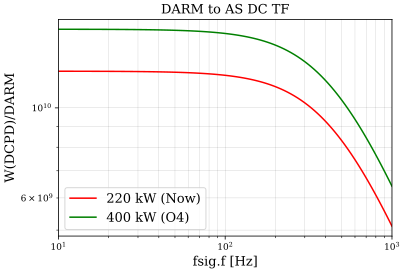

In [51]:
x = np.logspace(np.log10(10), np.log10(1000), num=100)

fig,ax =plt.subplots(1,1,figsize=(6,4))

ax.loglog(x, tf220, 'r', label='220 kW (Now)')
ax.loglog(x, tf400, 'g', label="400 kW (O4)")

ax.set_title("DARM to AS DC TF", fontsize=13)
ax.set_ylabel("W(DCPD)/DARM", fontsize=13)
ax.legend(loc = "best", fontsize=13)

# ax.set_ylabel("The difference", fontsize=13)
ax.set_xlabel("fsig.f [Hz]", fontsize=13);
fig.savefig('opticalgain.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);
print(tf400[10]/tf220[10])

In [95]:
def opticalGain(OM2Rc):
    LLObase1 = LLObase.deepcopy()

    LLObase1.OM2.Rc = OM2Rc

    opticalGains = []
    Pxs = []
    Pys = []
    for idx, Pin in enumerate(inputPower):
        kat = LLObase1.deepcopy()

        if OM2Rc == RoC20:
#             kat.DARM.DC = DARMDFUNC20(Pin, *popt20)
            kat.DARM.DC = DARMDC20[idx]
        elif OM2Rc == RoC40:
            kat.DARM.DC = DARMDC40[idx]
#             kat.DARM.DC = DARMDFUNC40(Pin, *popt40)
        elif OM2Rc == RoC60:
            kat.DARM.DC = DARMDC60[idx]
#             kat.DARM.DC = DARMDFUNC60(Pin, *popt60)
        else:
            print("Wrong RoC for the DARM offset")
        
        kat.L0.P = Pin

        PARM0 = ARMFinesse*43*Pin/np.pi
        Px = PARM0
        Py = PARM0
        for i in range(1, 7):
            if i!=6:
                kat = updateITMs(kat, Px, Py)
                Px, Py = getARMP(kat)
            else:
                kat = updateITMs(kat, Px, Py)
                OG, Px, Py = getARMP_OG(kat)
        
        Pxs.append(Px)
        Pys.append(Py)

        opticalGains.append(OG)

        del(kat)

        if idx%10 == 0:
            print(f"{idx} is done...")
            
    return [np.array(opticalGains), Pxs, Pys,]

In [96]:
def CarrierSignal(OM2Rc):
    LLObase1 = LLObase.deepcopy()

    LLObase1.OM2.Rc = OM2Rc

    Carrier = []
    Signal = []
    
    for idx, Pin in enumerate(inputPower):
        kat = LLObase1.deepcopy()

        if OM2Rc == RoC20:
#             kat.DARM.DC = DARMDFUNC20(Pin, *popt20)
            kat.DARM.DC = DARMDC20[idx]
        elif OM2Rc == RoC40:
            kat.DARM.DC = DARMDC40[idx]
#             kat.DARM.DC = DARMDFUNC40(Pin, *popt40)
        elif OM2Rc == RoC60:
            kat.DARM.DC = DARMDC60[idx]
#             kat.DARM.DC = DARMDFUNC60(Pin, *popt60)
                
        else:
            print("Wrong RoC for the DARM offset")
        
        kat.L0.P = Pin

        PARM0 = ARMFinesse*43*Pin/np.pi
        Px = PARM0
        Py = PARM0
        for i in range(1, 7):
            if i!=6:
                kat = updateITMs(kat, Px, Py)
                Px, Py = getARMP(kat)
            else:
                kat = updateITMs(kat, Px, Py)
                C, S, = getARMP_CarrierAMP(kat)

        Carrier.append(C)
        Signal.append(S)

        del(kat)

        if idx%10 == 0:
            print(f"{idx} is done...")
            
    return [np.array(Carrier), np.array(Signal)]

In [97]:
Carrier20, Signal20 = CarrierSignal(RoC20)
Carrier40, Signal40 = CarrierSignal(RoC40)
Carrier60, Signal60 = CarrierSignal(RoC60)

0 is done...
10 is done...
20 is done...
0 is done...
10 is done...
20 is done...
0 is done...
10 is done...
20 is done...


In [98]:
np.save("CarrierRoC20.npy", Carrier20)
np.save("SignalRoC20.npy", Signal20)

np.save("CarrierRoC40.npy", Carrier40)
np.save("SignalRoC40.npy", Signal40)

np.save("CarrierRoC60.npy", Carrier60)
np.save("SignalRoC60.npy", Signal60)

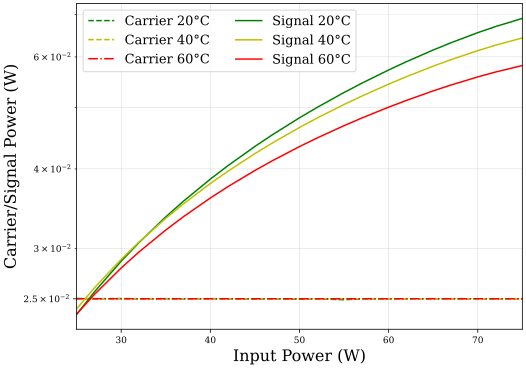

In [6]:
CarrierRoC20 = np.load("CarrierRoC20.npy")
SignalRoC20 = np.load("SignalRoC20.npy")

CarrierRoC40 = np.load("CarrierRoC40.npy")
SignalRoC40 = np.load("SignalRoC40.npy")

CarrierRoC60 = np.load("CarrierRoC60.npy")
SignalRoC60 = np.load("SignalRoC60.npy")

fig, ax = plt.subplots(figsize=(8,6))

Pin = inputPower

ax.semilogy(Pin, CarrierRoC20**2, "g--", label="Carrier 20°C")
ax.semilogy(Pin, CarrierRoC40**2, "y--", label="Carrier 40°C")
ax.semilogy(Pin, CarrierRoC60**2, "r-.", label="Carrier 60°C")

ax.semilogy(Pin, SignalRoC20**2, "g", label="Signal 20°C")
ax.semilogy(Pin, SignalRoC40**2, "y", label="Signal 40°C")
ax.semilogy(Pin, SignalRoC60**2, "r", label="Signal 60°C")

ax.set_xlabel("Input Power (W)", fontsize=16)
ax.set_ylabel("Carrier/Signal Power (W)", fontsize=16)
ax.legend(loc="best", ncol=2, fontsize=13);

lim = ax.get_ylim()
ax.set_yticks(list(ax.get_yticks()) + [0.025])
ax.set_ylim(lim)

fig.savefig('carriersignalPower.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [101]:
opticalGainsRoC20, PxssRoC20, PyssRoC20 = opticalGain(RoC20)
opticalGainsRoC40, PxssRoC40, PyssRoC40 = opticalGain(RoC40)
opticalGainsRoC60, PxssRoC60, PyssRoC60 = opticalGain(RoC60)

0 is done...
10 is done...
20 is done...
0 is done...
10 is done...
20 is done...
0 is done...
10 is done...
20 is done...


In [102]:
np.save("opticalGainsRoC20.npy", opticalGainsRoC20)
np.save("opticalGainsRoC40.npy", opticalGainsRoC40)
np.save("opticalGainsRoC60.npy", opticalGainsRoC60)

np.save("PxssRoC20.npy", PxssRoC20)
np.save("PxssRoC40.npy", PxssRoC40)
np.save("PxssRoC60.npy", PxssRoC60)

np.save("PyssRoC20.npy", PyssRoC20)
np.save("PyssRoC40.npy", PyssRoC40)
np.save("PyssRoC60.npy", PyssRoC60)

In [140]:
LLObase0 = LLObase.deepcopy()

LLObase0.OM2.Rc = RoC40

for Pin in [75]:
    kat = LLObase0.deepcopy()
    kat.L0.P = Pin
    kat.DARM.DC = 0.000993
    
    out = kat.run("""
    ad ASC2 OMC_OC.p3.o f=0
    noxaxis(pre_step=run_locks(method='newton', 
            display_progress=false, max_iterations=1000))
    """)
    
    print(np.abs(out["ASC2"])**2)

0.02500757888937598


In [153]:
LLObase1 = LLObase.deepcopy()
# LLObase1.modes("off")

LLObase1.OM2.Rc = RoC40

DARMDC40Non = [0.0017283, 0.0015767, 0.0014588, 0.00136377, 0.0012851, 0.0012186, 
          0.00116151, 0.0011115, 0.0010675, 0.0010282, 0.000993, 0.000961, 0.000932, 0.0009055]
inputPowerNon = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

opticalGainsPerfect_220 = []
for idx, Pin in enumerate(inputPowerNon):
    kat = LLObase1.deepcopy()
    kat.DARM.DC = DARMDC40Non[idx]
    
    kat.L0.P = Pin
    
    sol_lock = kat.run(RunLocks(method="proportional",
                                        display_progress=False,
                                        max_iterations=10000,
                                        scale_factor=1))

    out = kat.run(f"""
                fsig(1)
                frequency_response(
                [10],  # frequency vector
                [DARM,],  # injection nodes, dof DARM
                AS.DC,  # OMC_OC.p3.o DC, AS port
                )

     """) 
    
    if idx%30 == 0:
            print(f"{idx} is done...")
            
    opticalGainsPerfect_220.append(np.abs(out["frequency_response"]))
    del(kat)

0 is done...


In [154]:
np.save("opticalGainsPerfect_220.npy", opticalGainsPerfect_220)

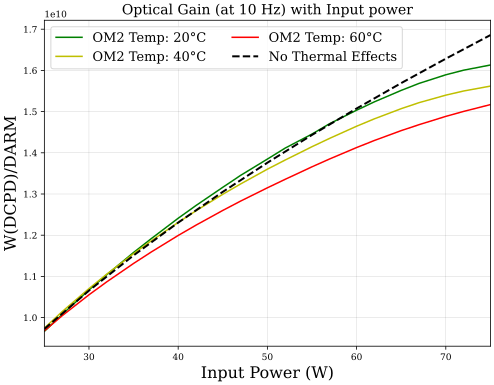

In [4]:
opticalGainsRoC20 = np.load("opticalGainsRoC20.npy")
opticalGainsRoC40 = np.load("opticalGainsRoC40.npy")
opticalGainsRoC60 = np.load("opticalGainsRoC60.npy")
opticalGainsPerfect_220 = np.load("opticalGainsPerfect_220.npy")

fig, ax = plt.subplots(figsize=(8,6))

Pin = np.array(inputPower)
inputPowerNon = np.array([25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])
ax.plot(Pin, opticalGainsRoC20, color='g', label="OM2 Temp: 20°C")
ax.plot(Pin, opticalGainsRoC40, 'y', label="OM2 Temp: 40°C")
ax.plot(Pin, opticalGainsRoC60, color='r', label="OM2 Temp: 60°C")
ax.plot(inputPowerNon, opticalGainsPerfect_220, 'k--', lw=2, label="No Thermal Effects")

# idx_400 = (np.abs(np.array(Pin)-76.75)).argmin()
# ax.scatter(40, opticalGainsRoC40[(np.abs(np.array(Pin)-40)).argmin()], s=50, label="220 kW (Now)")
# ax.scatter(Pin[idx_400], opticalGainsRoC40[idx_400], s=50, label="400 kW (O4)")

ax.set_xlabel("Input Power (W)", fontsize=16)
ax.set_ylabel("W(DCPD)/DARM", fontsize=16)
ax.set_title("Optical Gain (at 10 Hz) with Input power", fontsize=14)
ax.legend(loc="best", ncol=2, fontsize=13);
# fig.savefig('opticalgainarmpower.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

In [5]:
(opticalGainsRoC20[-1]-opticalGainsRoC40[-1])/(opticalGainsRoC40[-1]-opticalGainsRoC60[-1])

1.140573736379465

In [46]:
print(opticalGainsRoC40[np.abs(Pin-75).argmin()]/opticalGainsRoC40[np.abs(Pin-40).argmin()])
print(opticalGainsPerfect_220[10]/opticalGainsPerfect_220[3])

1.2687562075660497
1.369937783851844


In [48]:
np.sqrt(400/220)

1.348399724926484